##### Continuation from 'preprocessing_for_classification.ipynb'

In the previous notebook, we attempted to train Convolutional Neural Network (CNN) models to classify the images in the dataset. Specifically, we focused on classifying images into the two and three largest classes of the dataset.

In this notebook, our goals are:

1. **Classification Using Pre-trained Models**: 
   - We will utilize various pre-trained VGG16 to classify the images.

2. **Feature Extraction and Classifier Training**: 
   - We will extract features from the images using the aforementioned pre-trained models.
   - These extracted features will then be used to train various classifier models such as SVM, Random Forest, XGBoost, etc.


##### Import Libraries

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle
from xgboost import XGBClassifier
from sklearn.svm import SVC
from tensorflow.keras.preprocessing import image
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic
from skimage.segmentation import felzenszwalb
from tensorflow.keras.models import load_model
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear



In [2]:
data_path = r"Combined_images"
image_list = []
file_names = []

# Iterate over each file in the specified directory
for filename in os.listdir(data_path):
    if filename.endswith(('.jpg', '.png', '.tif', '.JPG')):
        file_path = os.path.join(data_path, filename)
        img = cv2.imread(file_path)
        # Append the image and its filename to the lists
        image_list.append(img)
        file_names.append(filename)

In [3]:
# Function to extract the number from the image filename
def extract_number_from_filename(filename):
    # Assuming the number is after 'combined_' and before the first '.'
    return filename.split('_')[1].split('.')[0]

clean_file_names = []

for name in file_names:
    clean_file_names.append(extract_number_from_filename(name))
    

images = image_list
image_names = clean_file_names

# Function to read the CSV and create a dictionary of image names to labels
def read_csv_to_dict(csv_file):
    df = pd.read_csv(csv_file)

    # Extract image names and labels
    image_names = df.iloc[:, 0].values
    labels = df.iloc[:, -1].values

    # Create a list of image-label pairs
    image_label_array = np.array([[name, label] for name, label in zip(image_names, labels)])
    
    # Convert the NumPy array to a dictionary
    image_label_dict = {row[0]: row[1] for row in image_label_array}
    return image_label_dict


# Function to create the list of images and their corresponding labels
def create_image_label_list(images, image_names, image_label_dict):
    image_label_list = []
    for image, name in zip(images, image_names):
        if name in image_label_dict:
            label = image_label_dict[name]
            image_label_list.append([name,image, label])
    return image_label_list

# Main execution
csv_file_path = 'image_labels.csv'
image_label_dict = read_csv_to_dict(csv_file_path)
image_label_list = create_image_label_list(images, image_names, image_label_dict)

In [54]:
two_largest_list = []
for instance in image_label_list:
    if instance[2]=='Misr' or instance[2]=='al-Mansuriyah'or instance[2]=='(al-Mansuriyah)':
        if instance[2]=='(al-Mansuriyah)':
            instance[2]='al-Mansuriyah'
        two_largest_list.append(instance)
        
print(f'Number of images: {len(two_largest_list)}')

Number of images: 452


In [4]:
data_path = 'Combined_images'

# Function to load and preprocess images
def load_and_preprocess_image(file_path):
    img = load_img(file_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array) # VGG16 preprocessing includes normalization
    return img_array

# Search for image files and load images and labels
images = []
image_labels = []
for key, label in image_label_dict.items():
    found = False
    for root, _, files in os.walk(data_path):
        for file in files:
            if key in file and (label == 'Misr' or label == 'al-Mansuriyah'):
                file_path = os.path.join(root, file)
                img_array = load_and_preprocess_image(file_path)
                images.append(img_array)
                image_labels.append(label)
                found = True
                break
        if found:
            break

# Convert to numpy arrays
images = np.array(images)
image_labels = np.array(image_labels)

# Encode labels as integers
label_to_index = {label: idx for idx, label in enumerate(np.unique(image_labels))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
image_labels = np.array([label_to_index[label] for label in image_labels])

# Split the dataset into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(images, image_labels, test_size=0.2, random_state=42, stratify=image_labels)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(label_to_index))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(label_to_index))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(label_to_index))

##### Load Pre-trained VGG16 Model

In [57]:
# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for transfer learning
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_to_index), activation='softmax')(x)

# Combine base model and new top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (not trainable)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
model.summary()

Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,02

 Total params: 40,931,650 (156.14 MB)

 Trainable params: 26,216,962 (100.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

##### Train the Model

In [59]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32
)

# Save the trained model
model.save('fine_tuned_vgg16.h5')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.2f}')

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.5707 - loss: 16.3142 - val_accuracy: 0.8310 - val_loss: 1.9424
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.6868 - loss: 6.7664 - val_accuracy: 0.9437 - val_loss: 0.6519
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.7755 - loss: 5.3791 - val_accuracy: 0.9577 - val_loss: 0.5904
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8668 - loss: 3.5290 - val_accuracy: 0.9014 - val_loss: 1.4499
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8565 - loss: 3.3173 - val_accuracy: 0.9437 - val_loss: 0.8507
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8717 - loss: 3.2116 - val_accuracy: 0.9437 - val_loss: 0.8006
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.9297 - loss: 1.1373 - val_accuracy: 0.9577 - val_loss: 1.0865
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.9017 - loss: 2.2108 - val_accuracy: 0.9437 - val_loss: 0.8000
Epoch 9

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9849 - loss: 0.6725
Test accuracy: 0.98


In [165]:
model = load_model('fine_tuned_vgg16.h5')

--- 
After training and testing the model, we want to understand how the model makes predictions.  
We will use Grad-CAM to visualize the regions of the image that the model uses to make predictions.


In [5]:

# Load and preprocess the image
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Display the heatmap
def display_heatmap(heatmap):
    plt.figure(figsize=(3,3))
    plt.imshow(heatmap[0])
    plt.axis('off')
    plt.show()

# Superimpose the Grad-CAM heatmap on the original image
def superimpose_heatmap_on_image(img_path, heatmap):
    # ajust figure size
    plt.figure(figsize=(6, 6))
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap[0], (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
# Define the main function to generate Grad-CAM heatmap
def generate_gradcam_heatmap(model_path, img_path):
    # Load the model
    model = load_model(model_path)

    # Preprocess the image
    img_array = load_and_preprocess_image(img_path)

    # Predict the class of the image
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    #print the real class
    print(f"Real class: {image_label_dict[img_path.split('/')[-1].split('_')[1].split('.')[0]]}")
    print(f"Predicted class: {index_to_label[predicted_class]}")
    

    # Define the loss for the target class
    score = CategoricalScore([predicted_class])

    # Create GradCAM object
    gradcam = Gradcam(model, model_modifier=ReplaceToLinear(), clone=False)

    # Generate heatmap
    heatmap = gradcam(score, img_array, penultimate_layer='block5_conv3')

    # Display heatmap
    # display_heatmap(heatmap)

    # Superimpose heatmap on original image
    superimpose_heatmap_on_image(img_path, heatmap)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Real class: Misr
Predicted class: Misr


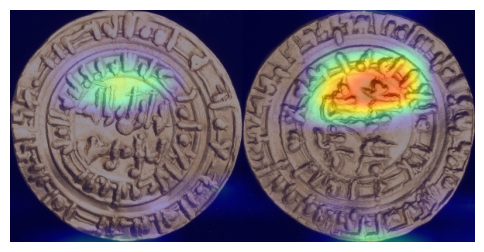

In [6]:
model_path = 'fine_tuned_vgg16.h5'
img_path = 'Combined_images/combined_151119.1.jpg_151119.2.jpg'

generate_gradcam_heatmap(model_path, img_path)

---
In the image above, we can see that the model is focusing on the center of the image, not close to the mint.  
We will try to blur this part of the image to see if the model will focus on the mint.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Real class: Misr
Predicted class: Misr


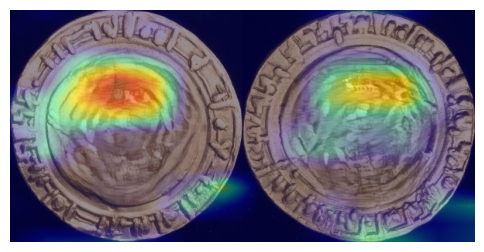

In [7]:
model_path = 'fine_tuned_vgg16.h5'
img_path = 'EDITED_IMAGES/blurred_151119.1.jpg_151119.2.jpg'

generate_gradcam_heatmap(model_path, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
Real class: Misr
Predicted class: Misr


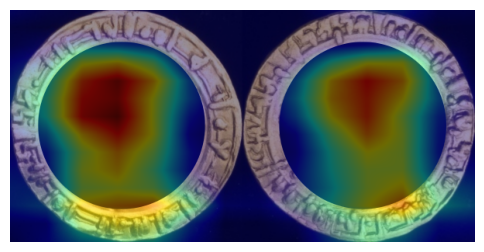

In [8]:
model_path = 'fine_tuned_vgg16.h5'
img_path = 'EDITED_IMAGES/remove_151119.1.jpg_151119.2.png'

generate_gradcam_heatmap(model_path, img_path)

---

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
Real class: al-Mansuriyah
Predicted class: al-Mansuriyah


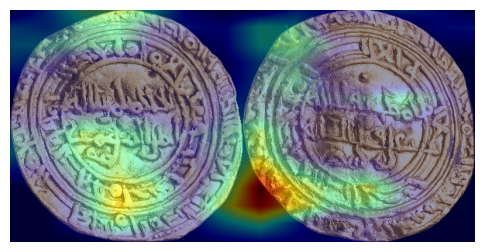

In [168]:
model_path = 'fine_tuned_vgg16.h5'
img_path = 'Combined_images/combined_150007.1.tif_150007.2.tif'

generate_gradcam_heatmap(model_path, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
Real class: al-Mansuriyah
Predicted class: al-Mansuriyah


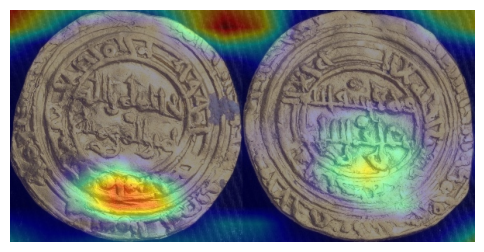

In [169]:
model_path = 'fine_tuned_vgg16.h5'
img_path = 'Combined_images/combined_150073.1.jpg_150073.2.jpg'

generate_gradcam_heatmap(model_path, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
Real class: Misr
Predicted class: Misr


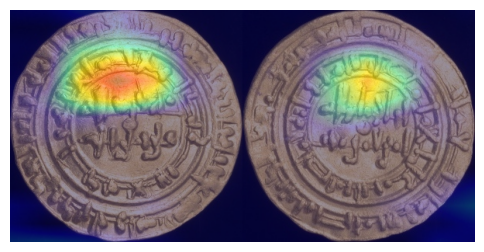

In [170]:
model_path = 'fine_tuned_vgg16.h5'
img_path = 'Combined_images/combined_151579.1.jpg_151579.2.jpg'

generate_gradcam_heatmap(model_path, img_path)

--- 

To better understand whether the model classifies the images based on the mint,<br>
we will perform an experiment where we remove the mint mark from one of the images and see if the model can still classify it correctly.<br>
This approach will help us determine if the model relies on the mint for classification or if it uses other features of the coins.

---

In [172]:
# plot both original and edited images
def plot_images(original, edited, title):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(edited)
    axes[1].set_title(title)
    axes[1].axis('off')
    plt.show()

In [173]:
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    prediction = model.predict(img_array)
    return prediction

#### Mist Image

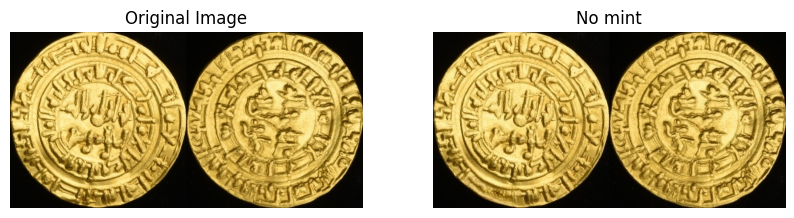

In [174]:
# Load the image
img_path = 'Combined_images/combined_151119.1.jpg_151119.2.jpg'  # Replace with your image path
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

no_mint_path = 'EDITED_IMAGES/combined_151119.1.jpg_151119.2.jpg'
no_mint = cv2.imread(no_mint_path)
no_mint = cv2.cvtColor(no_mint, cv2.COLOR_BGR2RGB)

plot_images(img, no_mint, 'No mint')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
Real class: Misr
Predicted class: Misr


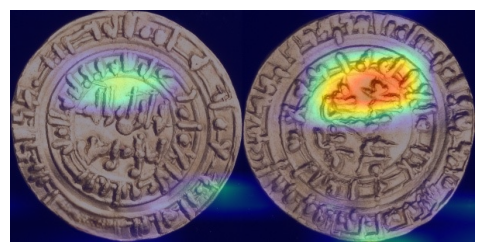

In [175]:
generate_gradcam_heatmap(model_path, no_mint_path)

##### Al-Mansuriya

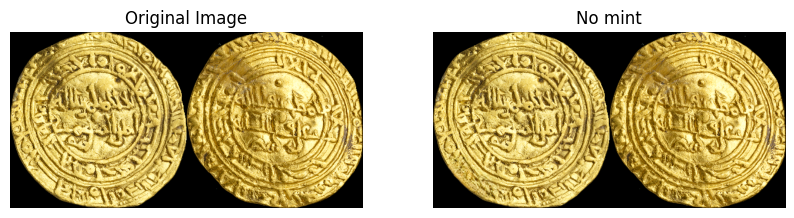

In [176]:
# Load the image
img_path = 'Combined_images/combined_150007.1.tif_150007.2.tif'  # Replace with your image path
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

no_mint_path = 'EDITED_IMAGES/combined_150007.1.tif_150007.2.tif'
no_mint = cv2.imread(no_mint_path)
no_mint = cv2.cvtColor(no_mint, cv2.COLOR_BGR2RGB)

plot_images(img, no_mint, 'No mint')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
Real class: al-Mansuriyah
Predicted class: al-Mansuriyah


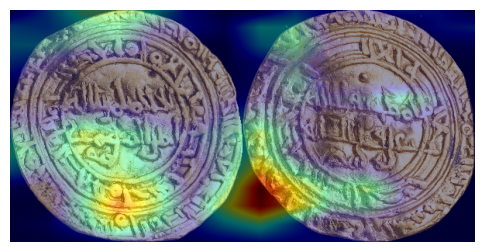

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
Real class: al-Mansuriyah
Predicted class: al-Mansuriyah


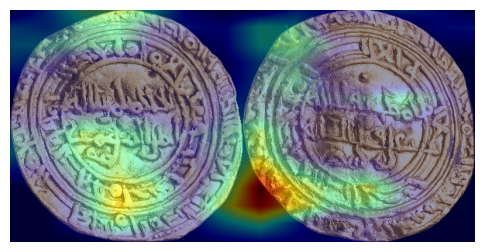

In [177]:
generate_gradcam_heatmap(model_path, no_mint_path)
generate_gradcam_heatmap(model_path, img_path)

##### Classify the 3 largest mints - Misr, al-Mahdiyah and al-Mansuriyah

In [178]:
# let's try to classify the 3 largest mints - Misr, al-Mahdiyah and al-Mansuriyah
data_path = 'Combined_images'


# Search for image files and load images and labels
images = []
image_labels = []
for key, label in image_label_dict.items():
    found = False
    for root, _, files in os.walk(data_path):
        for file in files:
            if key in file and (label == 'Misr' or label == 'al-Mansuriyah' or label == 'al-Mahdiyah'):
                file_path = os.path.join(root, file)
                img_array = load_and_preprocess_image(file_path)
                images.append(img_array)
                image_labels.append(label)
                found = True
                break
        if found:
            break

# Convert to numpy arrays
images = np.array(images)
image_labels = np.array(image_labels)

# Encode labels as integers
label_to_index = {label: idx for idx, label in enumerate(np.unique(image_labels))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
image_labels = np.array([label_to_index[label] for label in image_labels])

# Split the dataset into training, validation, and testing sets
X_train , X_test, y_train, y_test = train_test_split(images, image_labels, test_size=0.2, random_state=42, stratify=image_labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(label_to_index))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(label_to_index))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(label_to_index))

In [119]:
# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for transfer learning
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_to_index), activation='softmax')(x)

# Combine base model and new top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (not trainable)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [120]:
model.summary()

Model: "functional_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │         1,53

 Total params: 40,932,163 (156.14 MB)

 Trainable params: 26,217,475 (100.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [122]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32
)

# Save the trained model
model.save('fine_tuned_vgg16_3_mints.h5')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.2f}')

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step - accuracy: 0.5269 - loss: 14.4991 - val_accuracy: 0.7013 - val_loss: 6.0064
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.6417 - loss: 11.6320 - val_accuracy: 0.8052 - val_loss: 5.5222
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.7224 - loss: 7.7759 - val_accuracy: 0.7532 - val_loss: 5.1809
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.7192 - loss: 7.9092 - val_accuracy: 0.8442 - val_loss: 2.9424
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.7242 - loss: 4.9345 - val_accuracy: 0.8312 - val_loss: 3.4698
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.8244 - loss: 3.5770 - val_accuracy: 0.8571 - val_loss: 2.7913
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.8148 - loss: 2.9275 - val_accuracy: 0.8442 - val_loss: 1.9656
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.8580 - loss: 1.8328 - val_accuracy: 0.8312 - val_los

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.8594 - loss: 2.8746
Test accuracy: 0.88


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Real class: Misr
Predicted class: Misr


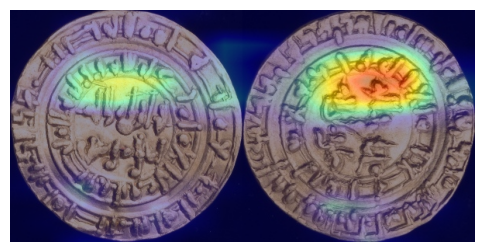

In [179]:
model_path = 'fine_tuned_vgg16_3_mints.h5'
img_path = 'Combined_images/combined_151119.1.jpg_151119.2.jpg'

generate_gradcam_heatmap(model_path, img_path)

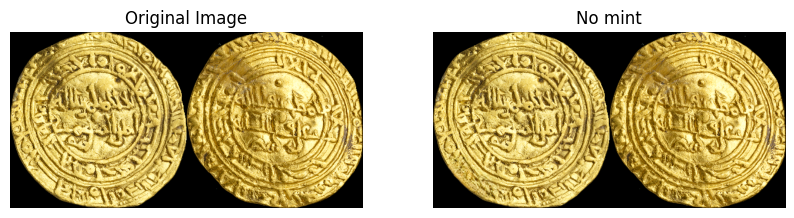

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Real class: al-Mansuriyah
Predicted class: al-Mansuriyah


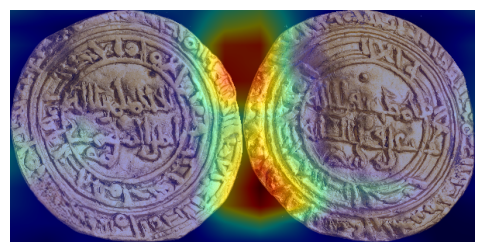

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
Real class: al-Mansuriyah
Predicted class: al-Mansuriyah


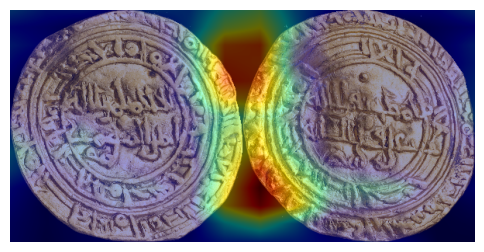

In [180]:
model_path = 'fine_tuned_vgg16_3_mints.h5'

img_path = 'Combined_images/combined_150007.1.tif_150007.2.tif' 
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

no_mint_path = 'EDITED_IMAGES/combined_150007.1.tif_150007.2.tif'
no_mint = cv2.imread(no_mint_path)
no_mint = cv2.cvtColor(no_mint, cv2.COLOR_BGR2RGB)

plot_images(img, no_mint, 'No mint')

generate_gradcam_heatmap(model_path, no_mint_path)
generate_gradcam_heatmap(model_path, img_path)

##### image from the third class: al-Mahdiyah

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
Real class: al-Mahdiyah
Predicted class: Misr


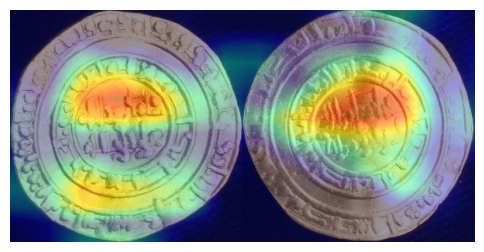

In [181]:
model_path = 'fine_tuned_vgg16_3_mints.h5'
img_path = 'Combined_images/combined_150424.1.JPG_150424.2.JPG'

generate_gradcam_heatmap(model_path, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
Real class: al-Mahdiyah
Predicted class: al-Mahdiyah


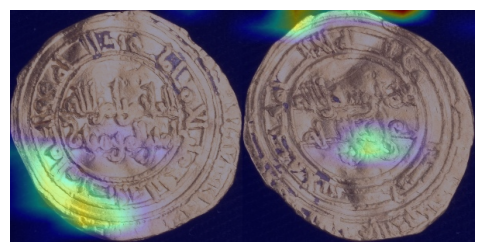

In [182]:

model_path = 'fine_tuned_vgg16_3_mints.h5'
img_path = 'Combined_images/combined_150443.1.JPG_150443.2.JPG'

generate_gradcam_heatmap(model_path, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
Real class: al-Mahdiyah
Predicted class: al-Mahdiyah


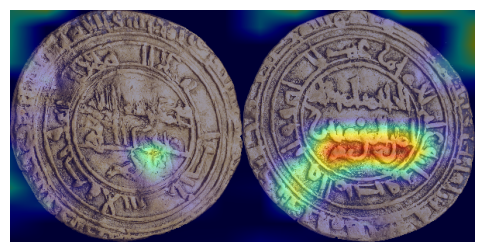

In [183]:
model_path = 'fine_tuned_vgg16_3_mints.h5'
img_path = 'Combined_images/combined_150016.1.tif_150016.2.tif'

generate_gradcam_heatmap(model_path, img_path)

In the picture above, the model correctly predicts the image as al-Mahdiyah.  
The Grad-CAM heatmap shows that the model focuses on the middle of the image for this prediction.  
Let's blur this central area and test whether the model can still correctly classify the image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
Real class: al-Mahdiyah
Predicted class: al-Mansuriyah


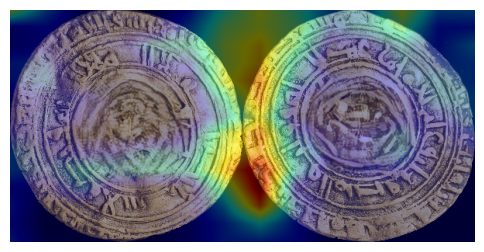

In [188]:
model_path = 'fine_tuned_vgg16_3_mints.h5'
img_path = 'EDITED_IMAGES/blurred_150016.1.tif_150016.2.tif'

generate_gradcam_heatmap(model_path, img_path)

As we can see, after blurring the central area of the image, the model is no longer able to predict the mint correctly

---

##### Features extraction using pretrained VGG16


In [129]:
# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 600, 3))

# Create a model to extract features
model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(model, images):
    features = []
    for img in images:
        img = preprocess_input(img)  # Preprocess the image as required by VGG16
        img = np.expand_dims(img, axis=0)  # Add a batch dimension
        feature = model.predict(img)
        features.append(feature.flatten())  # Flatten the feature map
    return np.array(features)

```python 
X_features = extract_features(model, X)

# save the model to disk
filename = 'features_model.sav'
pickle.dump(model, open(filename, 'wb'))

# save the features to disk
filename = 'features.sav'
pickle.dump(X_features, open(filename, 'wb'))
```

In [130]:
# load the features from disk
X_features = pickle.load(open('features.sav', 'rb'))

# Split the data into training and testing sets
X_train_features, X_test_features, y_train, y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42, stratify=Y)
X_train_features, X_val_features, y_train, y_val = train_test_split(X_train_features, y_train, test_size=0.2, random_state=42, stratify=y_train)


#### Logistic regression Model

In [131]:
# Train a logistic regression classifier
LogisticRegression_model = LogisticRegression(max_iter=1000)
LogisticRegression_model.fit(X_train_features, y_train)

# Evaluate the model
y_pred = LogisticRegression_model.predict(X_val_features)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation accuracy: {accuracy:.2f}')

# Test the model
y_test_pred = LogisticRegression_model.predict(X_test_features)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test accuracy: {test_accuracy:.2f}')

Validation accuracy: 0.96
Test accuracy: 0.92


#####  Xgboost Model

In [132]:
# Train xgboost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train_features, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_val_features)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation accuracy: {accuracy:.2f}')

# Test the model
y_test_pred = xgb_model.predict(X_test_features)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test accuracy: {test_accuracy:.2f}')

Validation accuracy: 0.86
Test accuracy: 0.85


##### SVM Model

In [133]:
# Train svm model
svm_model = SVC(C=1.0, kernel='linear')
svm_model.fit(X_train_features, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_val_features)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation accuracy: {accuracy:.2f}')

# Test the model
y_test_pred = svm_model.predict(X_test_features)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test accuracy: {test_accuracy:.2f}')

Validation accuracy: 0.95
Test accuracy: 0.93
